In [103]:
# Adapted from Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
import pandas as pd

class Rocket:
    g0 = 9.80665  # Gravitational acceleration on Earth surface [m/s^2]

    def __init__(self):
        
        
        self.M_dry = 43 + 4  # dry mass [kg]
        self.M_prop = 18     # propellant mass [kg]
        
        self.M_0 = self.M_dry + self.M_prop #launch mass [kg]
        
        
        self.r = (6*25.4*0.001/2) # body tube radius, [m]
        self.sref = np.pi*self.r**2  # area [m2]
        
        
        self.Isp = 200.0  # Isp [s]
        
        self.thrust_to_weight = 6  # initial thrust to weight ratio
        self.T_max = self.thrust_to_weight * self.M_0 * self.g0

    def air_density(self, h):
        beta = 1/8500.0  # scale factor [1/m]
        rho0 = 1.225  # kg/m3
        return rho0*np.exp(-beta*h)
    
    def speed_of_sound(self, h):
        #assumes h  is in meters, returns in m/s
        #determined from https://www.engineeringtoolbox.com/elevation-speed-sound-air-d_1534.html
        return -0.00389*h + 340.31598
    
    def drag(self, h, V):
        
        rho = self.air_density(h)
        a   = self.speed_of_sound(h)
        M   = V/a
        cd  = self.drag_coeff(M)
        
        q = (1/2)*rho*V**2
        
        drag = q*self.sref*cd
        
        return drag
        
    def drag_coeff(self, M):
        #polynomials determined from open_rocket export of rocket sized like U waterloo's 2018 rocket.
        #reference area is the rocket cross section. Data generated for 6 in diameter body tube. 
        
        def drag_coeff_single(M):
            
            coeff_sub = [ 0.62974538, -0.01151512,  0.11773826]
            coeff_tra = [-3.52610503,  7.99357459, -3.72820877]
            coeff_sup = [ 1.09641739, -0.45894398,  0.07741472]
            
            if M<1:
                coeff = coeff_sub
            elif M>1.25:
                coeff = coeff_sup
            else:
                coeff = coeff_tra
                
            cd = np.polynomial.polynomial.polyval(M,coeff)
            
            return cd
        
        M = np.array(M)
        
        if M.size == 1:
            #act on a single data point
            return drag_coeff_single(M)
        
        else:
            #assumes M is a vector
            cd = np.array([drag_coeff_single(mi) for mi in M])
            return cd

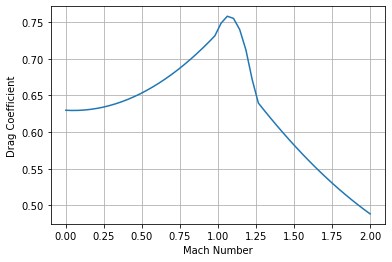

In [99]:
#verify drag model
rocket = Rocket()
M =np.linspace(0,2)
cds=rocket.drag_coeff(M)
plt.plot(M,cds)
plt.grid(True)
plt.xlabel('Mach Number')
plt.ylabel('Drag Coefficient');

In [100]:
rocket.T_max

3824.5935

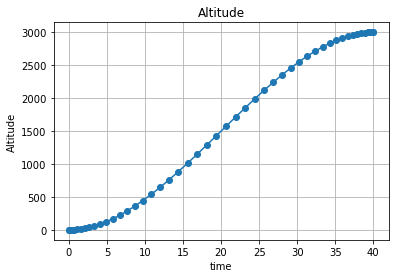

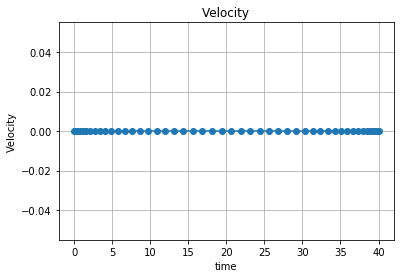

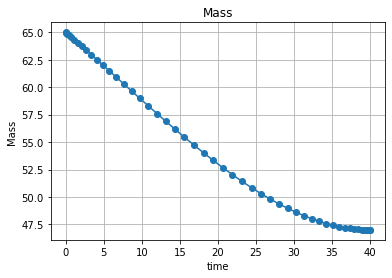

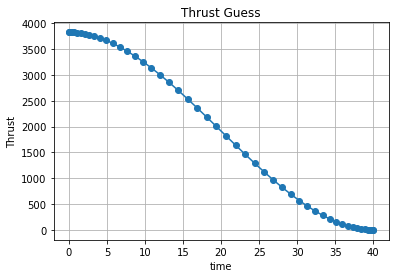

In [109]:
def dynamics(prob, obj, section):
    h = prob.states(0, section)
    v = prob.states(1, section)
    m = prob.states(2, section)
    
    T = prob.controls(0, section)
    
    drag = obj.drag(h,v)

    Isp = obj.Isp
    g0  = obj.g0
    
    dx = Dynamics(prob, section)
    dx[0] = v
    dx[1] = (T - drag) / m - g0
    dx[2] = - T / (Isp*g0)
    
    return dx()


def equality(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    T = prob.controls_all_section(0)
    
    tf = prob.time_final(-1)

    result = Condition()

    # event condition
    result.equal(h[0], 0.0)
    result.equal(v[0], 0.0)
    result.equal(m[0], obj.M_0)
    result.equal(v[-1], 0.0)
    result.equal(m[-1], obj.M_dry)

    return result()


def inequality(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    T = prob.controls_all_section(0)
    tf = prob.time_final(-1)

    result = Condition()
    # lower bounds
    result.lower_bound(h, 0)
    result.lower_bound(v, 0.0)
    result.lower_bound(m, obj.M_dry)
    result.lower_bound(T, 0.0)
    result.lower_bound(tf, 10)
    # upper bounds
    result.upper_bound(m, obj.M_0)
    result.upper_bound(T, obj.T_max)

    return result()


def cost(prob, obj):
    h = prob.states_all_section(0)
    return - h[-1]


def cost_derivative(prob, obj):
    jac = Condition(prob.number_of_variables)
    index_h_end = prob.index_states(0, 0, -1)
    jac.change_value(index_h_end, -1)
    return jac()



time_init = [0.0, 40]
n = [50]
num_states = [3]
num_controls = [1]
max_iteration = 20

flag_savefig = True
savefig_file = "./Basic_Single_Stage/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)

# ------------------------
# create instance of operating object
obj = Rocket()

# ------------------------
# set designer unit
#unit_R = obj.Re
#unit_v = np.sqrt(obj.GMe / obj.Re)
#unit_m = obj.M0
#unit_t = unit_R / unit_v
#unit_T = unit_m * unit_R / unit_t**2
#prob.set_unit_states_all_section(0, unit_R)
#prob.set_unit_states_all_section(1, unit_v)
#prob.set_unit_states_all_section(2, unit_m)
#prob.set_unit_controls_all_section(0, unit_T)
#prob.set_unit_time(unit_t)

# ========================
# Initial parameter guess

# altitude profile
h_init = Guess.cubic(prob.time_all_section, 0, 0.0, 3000, 0.0)
Guess.plot(prob.time_all_section, h_init, "Altitude", "time", "Altitude")
# if(flag_savefig):plt.savefig(savefig_file + "guess_alt" + ".png")

# velocity
V_init = Guess.linear(prob.time_all_section, 0.0, 0.0)
Guess.plot(prob.time_all_section, V_init, "Velocity", "time", "Velocity")

# mass profile
M_init = Guess.cubic(prob.time_all_section, obj.M_0, -0.6, obj.M_dry, 0.0)
Guess.plot(prob.time_all_section, M_init, "Mass", "time", "Mass")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

# thrust profile
T_init = Guess.cubic(prob.time_all_section, obj.T_max, 0.0, 0.0, 0.0)
Guess.plot(prob.time_all_section, T_init, "Thrust Guess", "time", "Thrust")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

plt.show()


In [110]:
# ========================
# Substitution initial value to parameter vector to be optimized
prob.set_states_all_section(0, h_init)
prob.set_states_all_section(1, V_init)
prob.set_states_all_section(2, M_init)
prob.set_controls_all_section(0, T_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
# prob.cost_derivative = cost_derivative
prob.equality = equality
prob.inequality = inequality


def display_func():
    h = prob.states_all_section(0)
    print("max altitude: {0:.5f} m".format(h[-1]))

prob.solve(obj, display_func, ftol=1e-12)



---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -4460.41121065371
            Iterations: 26
            Function evaluations: 5301
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 4460.41121 m

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -5033.370987210981
            Iterations: 26
            Function evaluations: 5281
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 5033.37099 m

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -5193.1803776884935
            Iterations: 26
            Function evaluations: 5278
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 5193.18038 m

---- iteration : 4 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -5340.39407085159
            Iterations: 26
            Function e

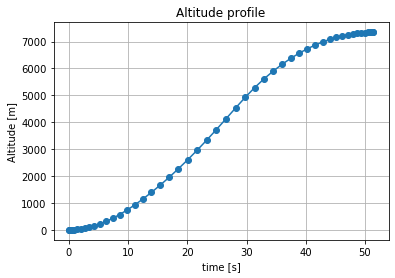

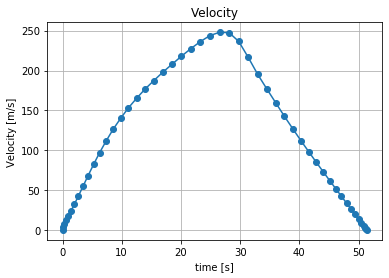

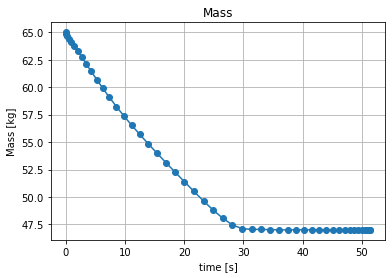

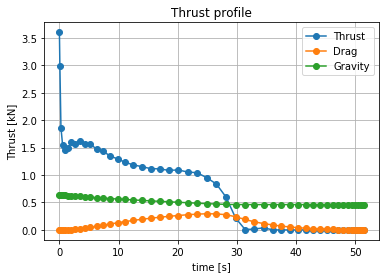

In [116]:

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
h = prob.states_all_section(0)
v = prob.states_all_section(1)
m = prob.states_all_section(2)
T = prob.controls_all_section(0)
time = prob.time_update()

# ------------------------
# Calculate necessary variables

drag = obj.drag(h,v)
g0   = obj.g0

# ------------------------
# Visualizetion
plt.figure()
plt.title("Altitude profile")
plt.plot(time, h, marker="o", label="Altitude")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [m]")
if(flag_savefig): plt.savefig(savefig_file + "altitude" + ".png")

plt.figure()
plt.title("Velocity")
plt.plot(time, v, marker="o", label="Velocity")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [m/s]")
if(flag_savefig): plt.savefig(savefig_file + "velocity" + ".png")

plt.figure()
plt.title("Mass")
plt.plot(time, m, marker="o", label="Mass")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [kg]")
if(flag_savefig): plt.savefig(savefig_file + "mass" + ".png")

plt.figure()
plt.title("Thrust profile")
plt.plot(time, T / 1000, marker="o", label="Thrust")
plt.plot(time, drag / 1000, marker="o", label="Drag")
plt.plot(time, m * g0 / 1000, marker="o", label="Gravity")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [kN]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "force" + ".png")

plt.show()